В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [37]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [9]:
!git clone https://github.com/natasha-kolom/Machine_learning.git

Cloning into 'Machine_learning'...


In [10]:
repo_path = os.path.abspath("Machine_learning")
sys.path.append(repo_path)

In [11]:
from process_bank_churn import preprocess_data

In [13]:
raw_df = pd.read_csv('C:/Users/dcmaterik_1/Documents/ML_for_people/Lessons/Lesson 5 Logistic Regression/kaggle competition/bank-customer-churn-prediction-dlu/train.csv')

In [14]:
numeric_cols = [
 'Age',
 'Balance',
 'CreditScore',
 'IsActiveMember',
 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender','NumOfProducts' ]

In [18]:
data = preprocess_data(raw_df, 'Exited', scaler_numeric=True, categorical_cols=categorical_cols,numeric_cols = numeric_cols)
X_train = data['X_train']
train_targets = data['train_targets']
X_val = data['X_val']
val_targets = data['val_targets']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [24]:
y_pred_proba = knn.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(train_targets, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUROC: {roc_auc:.2f}')

AUROC: 0.96


In [25]:
y_pred_proba_val = knn.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(val_targets, y_pred_proba_val)
roc_auc = auc(fpr, tpr)
print(f'AUROC val: {roc_auc:.2f}')

AUROC val: 0.88


**Спостереження**
Вважаю, що ця модель перенавчена, тому що дуже викосий аурок на тренувальних даних (0.96), та значно нижче не валідаційних (0.88)

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [29]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [33]:
knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 9} 0.889


In [34]:
y_pred_proba = knn_gs.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(train_targets, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUROC: {roc_auc:.2f}')

AUROC: 0.95


In [35]:
y_pred_proba_val = knn_gs.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(val_targets, y_pred_proba_val)
roc_auc = auc(fpr, tpr)
print(f'AUROC val: {roc_auc:.2f}')

AUROC val: 0.90


**Спостереження**
Ця модель краще за попередню та краще за Дерева прийняття рішень, так як там мені вдалося досягти аурок  0.93

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [69]:
%%time
dt = DecisionTreeClassifier(random_state=42)
params_dt = {'max_depth': np.arange(1, 20, 2),
            'max_leaf_nodes': np.arange(2,10)}
dt_gs = GridSearchCV(dt, params_dt, cv=3, scoring='roc_auc')
dt_gs.fit(X_train, train_targets)

CPU times: total: 4.28 s
Wall time: 4.28 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [70]:
dt_best = dt_gs.best_estimator_
print(dt_gs.best_params_, dt_gs.best_score_)

{'max_depth': 5, 'max_leaf_nodes': 9} 0.8984450552247162


In [71]:
y_pred_proba = dt_gs.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(train_targets, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUROC: {roc_auc:.2f}')

AUROC: 0.90


In [72]:
y_pred_proba_val = dt_gs.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(val_targets, y_pred_proba_val)
roc_auc = auc(fpr, tpr)
print(f'AUROC val: {roc_auc:.2f}')

AUROC val: 0.90


**Спостереження** Скор цієї моделі трішки гірше, ніж знайений мною вручну(мій скор 0.93), але тут аурок на валідаційних та тренувальних даних співпадає, тому можливо ця модель краще генералізує

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [43]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [50]:
dt = DecisionTreeClassifier(random_state=42)

In [45]:
from sklearn.model_selection import RandomizedSearchCV

In [52]:
%%time
search = RandomizedSearchCV(
    dt,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring='roc_auc',
    refit=True
)
search.fit(X_train, train_targets)

CPU times: total: 2.09 s
Wall time: 2.12 s


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   scoring='roc_auc')

In [53]:
dt_random_search_best = search.best_estimator_

In [54]:
display(search.best_estimator_, search.best_score_)

DecisionTreeClassifier(max_depth=15, max_leaf_nodes=9, random_state=42)

0.8984450552247162

In [55]:
y_pred_proba = search.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(train_targets, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUROC: {roc_auc:.2f}')

AUROC: 0.90


In [56]:
y_pred_proba_val = search.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(val_targets, y_pred_proba_val)
roc_auc = auc(fpr, tpr)
print(f'AUROC val: {roc_auc:.2f}')

AUROC val: 0.90


**Спостереження**
Пошук по RandomizedSearchCV дав такий самий результат, як і пошук по сітці

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [57]:
from process_bank_churn import preprocess_new_data

In [58]:
X_test = pd.read_csv('C:/Users/dcmaterik_1/Documents/ML_for_people/Lessons/Lesson 5 Logistic Regression/kaggle competition/bank-customer-churn-prediction-dlu/test.csv')

In [59]:
new_data = preprocess_new_data(X_test, data['preprocessor'])

In [61]:
y_pred_proba = knn_gs.predict_proba(new_data)[:, 1]

In [62]:
import warnings
warnings.filterwarnings("ignore")


X_test['Exited'] = y_pred_proba
sample_submission = pd.read_csv('C:/Users/dcmaterik_1/Documents/ML_for_people/Lessons/Lesson 5 Logistic Regression/kaggle competition/bank-customer-churn-prediction-dlu/sample_submission.csv')
merged_df = sample_submission.merge(X_test, on='id', how='left')
merged_df['Exited'] = merged_df['Exited_y']
merged_df = merged_df[['id', 'Exited']]

In [63]:
merged_df.to_csv('submission_knn.csv', index=False)

In [73]:
y_pred_proba = dt_gs.predict_proba(new_data)[:, 1]

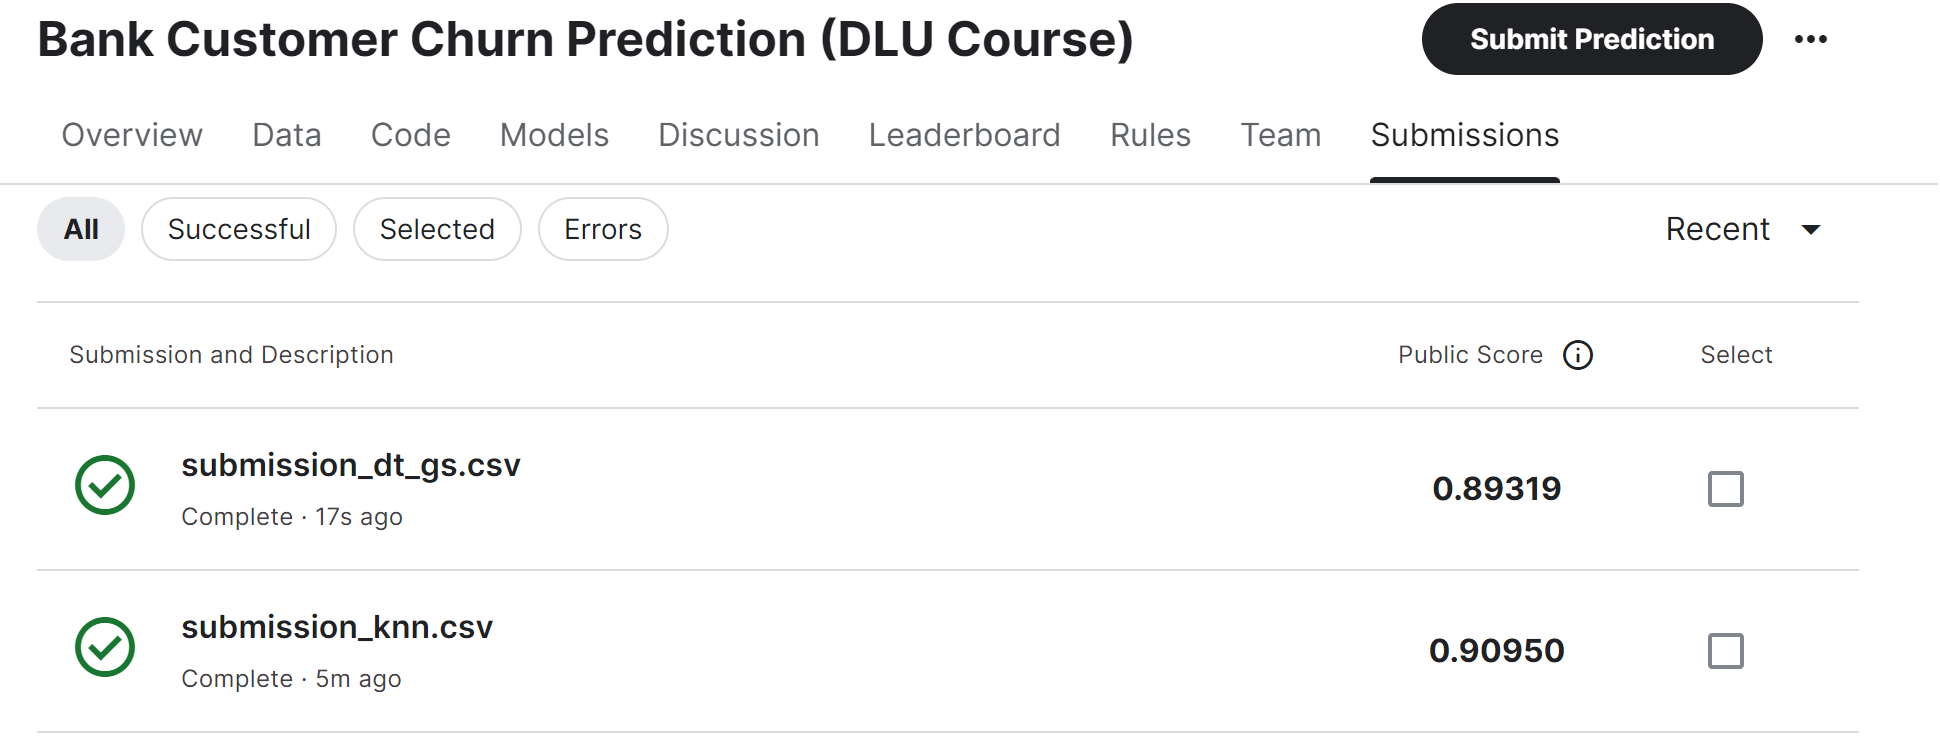

**Спостереження**
В цих експериментах в мене найкраще спрацювала модель Кнн, але в змаганнях скор вийшов все-одно менший, ніж я досягла з логістичною регресією.